In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mnist

#munge data from mnist
rawX = mnist.train_images().astype(np.float32)
def subsample(X,step=3):
    return np.array([im[0::step,0::step] for im in X])
rawX = subsample(rawX)

allX = rawX.reshape(60000,np.prod(rawX.shape[1:])) #flatten it
ally = mnist.train_labels()
keep = ally<2
allX = allX[keep,:]
ally = ally[keep]
ally = ally[:,None]
X = allX[0:300,:]
y = ally[0:300,:]
testX = allX[500:600,:]
testy = ally[500:600,:]

# GP Simple Classifier

Here we demonstrate attacking the simple GP classifier

In [2]:
#build model
from GPadversarial import simple
m = simple.build_model(X,y)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.879760e+02           nan 
    00s16  0003   1.890708e+02   3.788846e-01 
    01s21  0023   2.163814e+01   1.562007e-04 
    01s90  0035   2.133011e+01   2.556945e-13 
Runtime:     01s90
Optimization status: Converged



In [3]:
m

gp_classification.,value,constraints,priors
rbf.variance,181.599243321,+ve,
rbf.lengthscale,2049.98661368,+ve,


In [4]:
#compute classification accuracy on test data.
pred, _ = m.predict(testX)
np.mean((pred>0.5)==(testy==1))

1.0

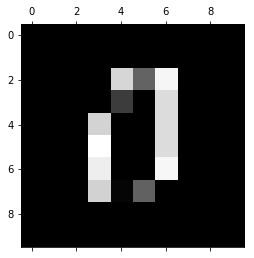

In [5]:
#a digit...
plt.matshow(testX[0:1,:].reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

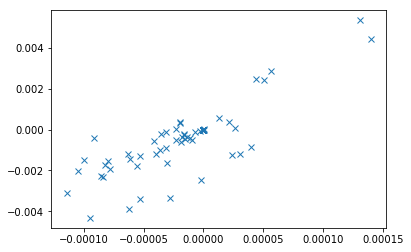

In [6]:
#the gradient of the latent function f and the posterior pi,
#are not necessarily completely proportional, as it depends on how far 
#from 0 the latent function is, and its variance:
fgrads = simple.get_numerical_f_grad(m,testX[0:1,:].copy())
pigrads = simple.get_numerical_pi_grad(m,testX[0:1,:].copy())
est = simple.calc_df_dx(m,testX[0:1,:].copy())
plt.plot(pigrads,est,'x')

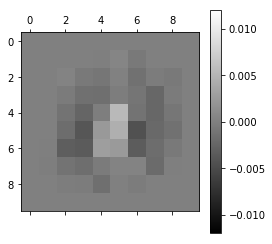

In [7]:
#let's see the saliency map
plt.matshow(est.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray',clim=[-0.012,0.012])
plt.colorbar()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s17  0003   1.893301e+02   2.667624e-02 
    01s18  0021   1.960335e+02   1.034099e+02 
    02s19  0037   1.864171e+01   2.482143e-05 

 /home/mike/GPy/GPy/kern/src/stationary.py:129: RuntimeWarning:overflow encountered in square
 /home/mike/GPy/GPy/kern/src/stationary.py:130: RuntimeWarning:invalid value encountered in add



Runtime:     02s19
Optimization status: Converged



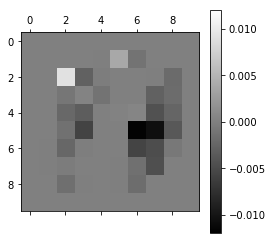

In [8]:
#side note, you'll notice the saliency map is very different if we turn on ARD. 
#This means each pixel can have a different lengthscale;
mARDon = simple.build_model(X,y,ARD=True)
estARDon = simple.calc_df_dx(mARDon,testX[0:1,:].copy())
plt.matshow(estARDon.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray',clim=[-0.012,0.012])
plt.colorbar()

Before and after...
Crossed boundary after 4 changes


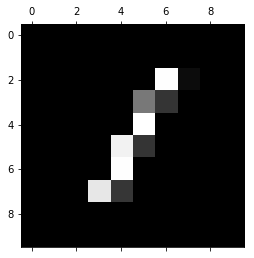

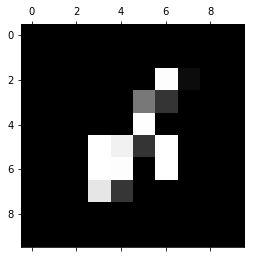

In [9]:
#launching an attack...
#hint, try changing the 'changedir'
print("Before and after...")
advX = testX[1:2,:].copy() #the initial test point we're going to use...
plt.matshow(advX.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')
advsample, pred, N = simple.generate_adversarial_example(m, advX, changedir=+1)
if advsample is not None:
    print("Crossed boundary after %d changes" % N)
    plt.matshow(advsample.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')
else:
    print("Failed to find adversarial example")

# GP LVM

Here we demonstrate two attacks of the GP LVM.

In latent space we make predictions using a simple linear classifier

In [3]:
from GPadversarial import lvm
m, clf = lvm.build_model(X,y)

NameError: name 'X' is not defined

(-150, 150)

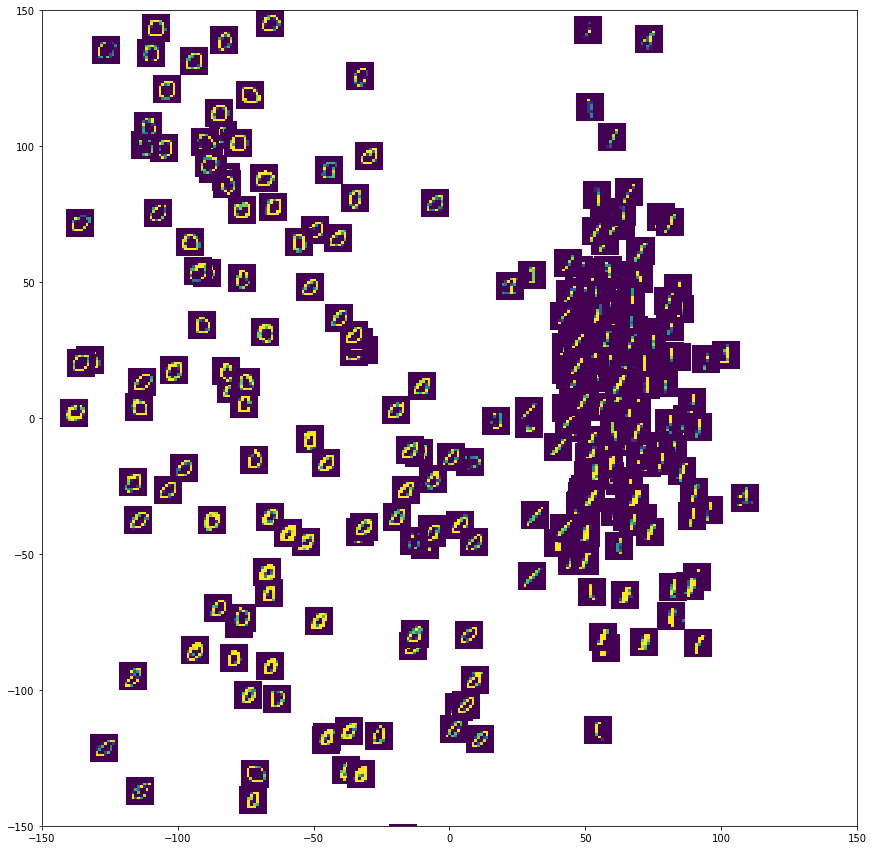

In [11]:
fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111)
for i,x in enumerate(m.X):
    im = ax.imshow(X[i,:].reshape(10,10),extent=[x[0],x[0]+10,x[1],x[1]+10])
plt.xlim([-150,150])
plt.ylim([-150,150])

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


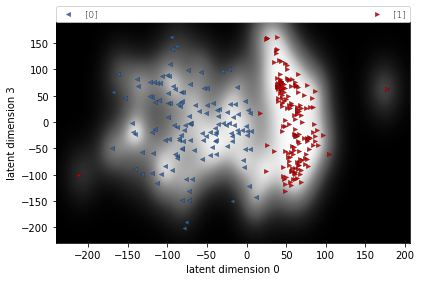

In [12]:
m.plot_latent(labels=y)

In [13]:
#proportion of test points correctly classified.
print(np.mean(clf.predict(m.infer_newX(testX)[0].values)==testy[:,0]))

 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


1.0


[[-40.19141543]] [[ 2.87224788]]


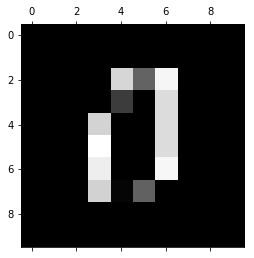

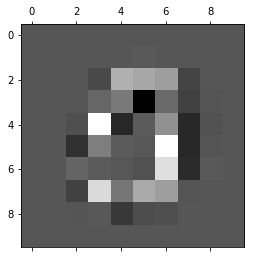

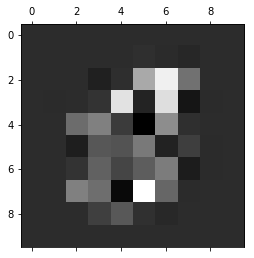

In [14]:
advX = testX[0:1,:].copy() #the initial test point we're going to use...
plt.matshow(advX.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

advsample, intermediatesample = lvm.generate_adversarial_example_near_boundary(m,clf,advX)
plt.matshow(advsample.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')
plt.matshow(intermediatesample.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

In [15]:
print(lvm.get_pred(m,clf,advX))
print(lvm.get_pred(m,clf,intermediatesample))
print(lvm.get_pred(m,clf,advsample))

[[-40.19141543]]
[[ 3.21708254]]
[[ 41.88027802]]


The earlier pair of scores is for the seed point, and the point just after one has crossed the boundary: In my run it goes from -38 to +4. I found that searching along the boundary can lead to the actual value becoming further from 0; but, presumably the pixels get closer.

#### GPLVM pixel-by-pixel

This never seems to converge or find a solution.

In 'Bruteforce' I look at changing more than one pixel, that seems to work quite well.

[[ 14.05695112]]
[[ 14.70926493]]
[[ 13.45978707]]
[[ 13.48131103]]
[[ 35.16691836]]
[[ 32.09243904]]
[[ 28.69793921]]
[[ 28.63617922]]
[[ 28.1518261]]
[[ 28.05155548]]
[[ 27.91029392]]
[[ 27.91029392]]
[[ 27.91029392]]
[[ 27.91029392]]
[[ 27.91029392]]
[[ 27.91029392]]
[[ 27.52164013]]
[[ 26.49009005]]
[[ 26.49009005]]
[[ 26.49009005]]
[[ 26.49009005]]
[[ 26.49009005]]
[[ 26.49009005]]
[[ 26.49009005]]
[[ 26.49009005]]
[[ 26.49009005]]
[[ 26.49009005]]
[[ 26.49009005]]
[[ 26.49009005]]
[[ 26.49009005]]
[[ 26.49009005]]
[[ 26.49009005]]


KeyboardInterrupt: 

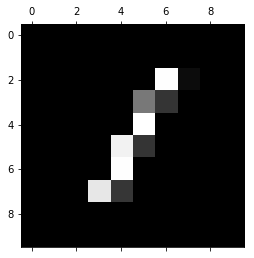

In [17]:
advX = testX[1:2,:].copy() #the initial test point we're going to use...
plt.matshow(advX.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

advsample, intermediatesample = lvm.generate_adversarial_example(m,clf,advX)
plt.matshow(advsample.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')
plt.matshow(intermediatesample.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

# GPLVM with GPClassifier on top

In [1]:
from GPadversarial import lvm_gp

import GPy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mnist

#munge data from mnist
rawX = mnist.train_images().astype(np.float32)
def subsample(X,step=3):
    return np.array([im[0::step,0::step] for im in X])
rawX = subsample(rawX)

allX = rawX.reshape(60000,np.prod(rawX.shape[1:])) #flatten it
ally = mnist.train_labels()
keep = ally<2
allX = allX[keep,:]
ally = ally[keep]
ally = ally[:,None]
X = allX[0:300,:]
y = ally[0:300,:]
testX = allX[500:600,:]
testy = ally[500:600,:]

In [2]:
m, m2 = lvm_gp.build_model(X,y)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    01s28  011   1.220129e+06   1.151420e+10 
    03s32  031   1.538306e+05   1.684672e+04 
    04s42  041   1.525463e+05   1.526415e+03 
    10s08  102   1.506381e+05   5.471613e+02 
Runtime:     10s08
Optimization status: Maximum number of f evaluations reached



 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


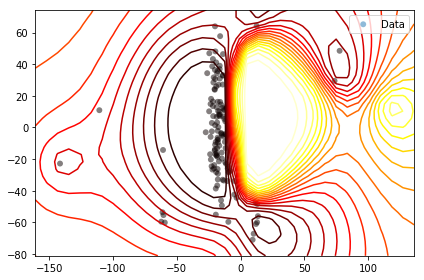

In [3]:
m2.plot()

In [8]:
advX = testX[1:2,:].copy() #the initial test point we're going to use...

lvm_gp.get_pred(m,m2,advX)

array([[ 0.99887406]])

In [ ]:
advsample, latent_advsample, pred = lvm_gp.generate_adversarial_example(m,m2,advX)

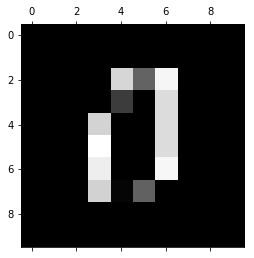

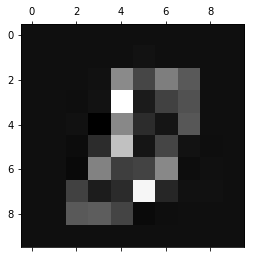

In [7]:
plt.matshow(advX.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')
plt.matshow(advsample.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')